# 0.0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor

from boruta import BorutaPy
from IPython.display import Image
from IPython.core.display import HTML
from tabulate import tabulate
from scipy import stats

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    chi2 = stats.chi2_contingency( cm )[0]
    n = cm.sum()
    r, k = cm.shape
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2/n)/ (min(kcorr-1,rcorr-1)))

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv("data/train.csv", low_memory = False)
df_store_raw = pd.read_csv("data/store.csv", low_memory = False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
6097,523,7,2015-07-26,0,0,0,0,0,0,c,c,50.0,11.0,2013.0,0,NaN,NaN,NaN


# 1.0. DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x:inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename

df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [9]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of columns: {}".format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
#changing date's type
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [12]:
df1.isna().sum().sort_values(ascending = False)

promo_interval                  508031
promo2_since_week               508031
promo2_since_year               508031
competition_open_since_year     323348
competition_open_since_month    323348
competition_distance              2642
open                                 0
day_of_week                          0
date                                 0
sales                                0
customers                            0
school_holiday                       0
promo                                0
state_holiday                        0
store_type                           0
assortment                           0
promo2                               0
store                                0
dtype: int64

## 1.5. Fillout NA

In [13]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [14]:
df1.isnull().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes(include = ['int64','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64','float64','datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [18]:
#Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T


m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

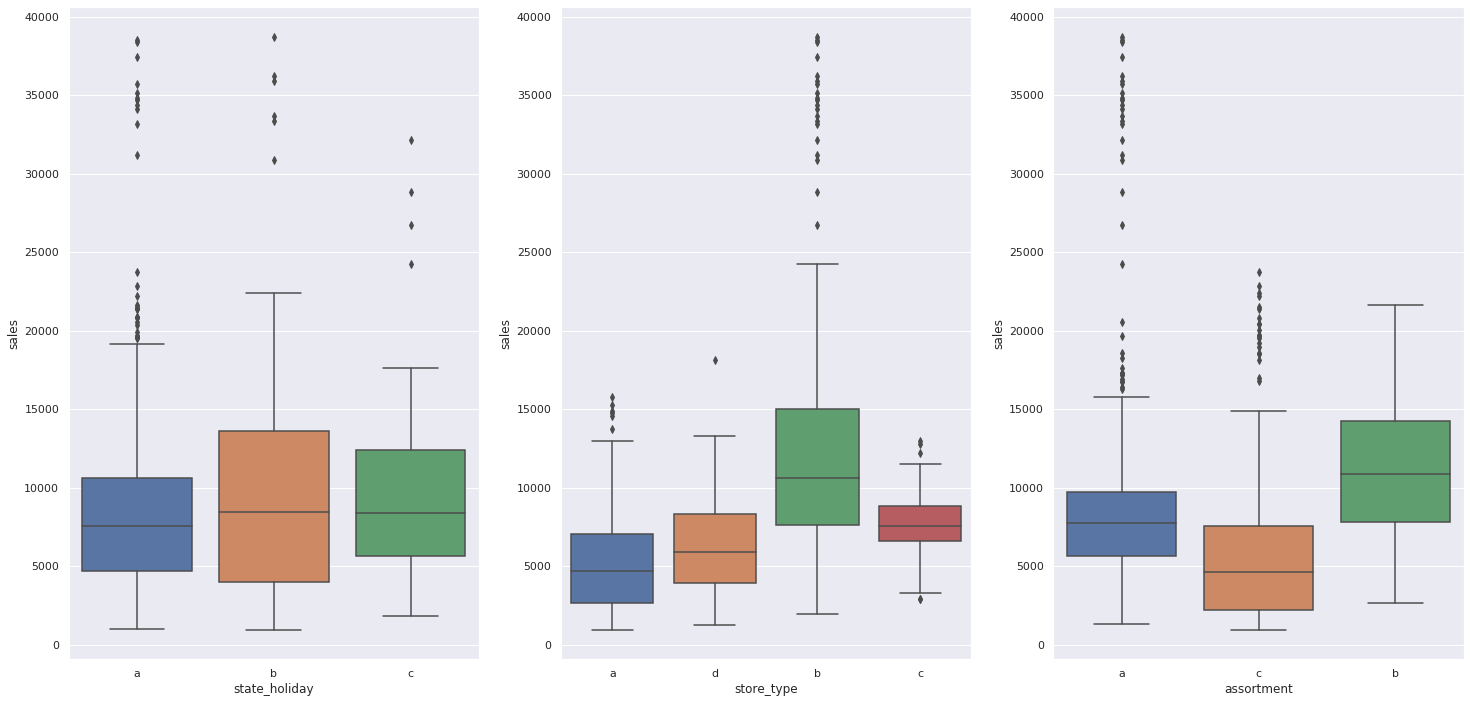

In [20]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0 )]

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type',y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)

# 2.0. FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

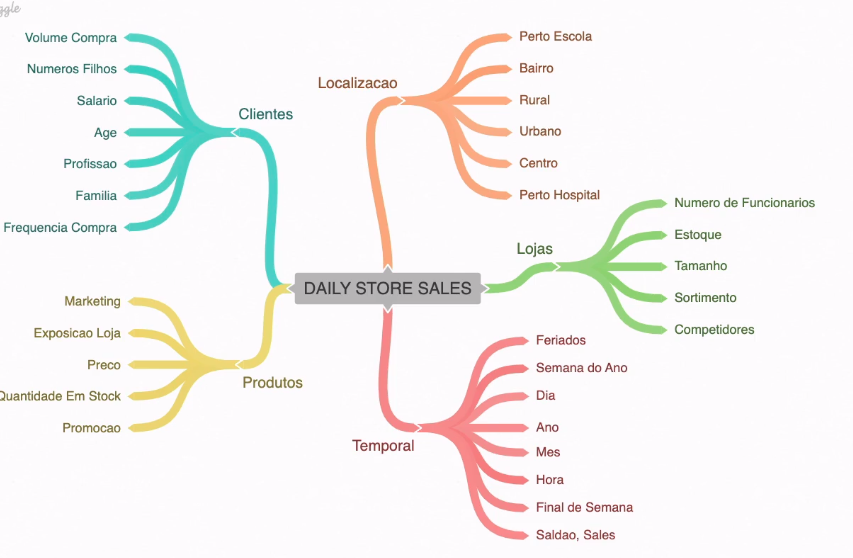

In [22]:
Image("img/MindMapHypothesis.png")

## 2.1. Criação das Hipóteses

### 2.1.1. Hipóteses da Lojas

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores a mais tempo deveriam vender mais

### 2.1.2. Hipóteses do Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expõe mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores deveriam vender mais.

**4.** Lojas que tem promoções mais agressivas(descontos maiores), deveriam vender mais

**5.** Lojas que tem preços menos por mais tempo nos produtos deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipóteses do Tempo

**1.** Lojas abertas durante o feriado deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.


## 2.2. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais

**4.** Lojas que tem preços menos por mais tempo nos produtos deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 2.3. Feature Engineering

In [23]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment 
#a = basic, b = extra, c = extended

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state_holiday
#a = public_holiday, b = easter holiday c = christmas

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')




# 3.0. FILTRAGEM DAS VARIÁVEIS

In [24]:
df3 = df2.copy()

In [25]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [26]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtragem das Colunas

In [27]:
df3.drop(columns = ['customers','open','promo_interval','month_map'], axis = 1, inplace = True)
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. ANÁLISE EXPLORATÓRIA DE DADOS

In [28]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

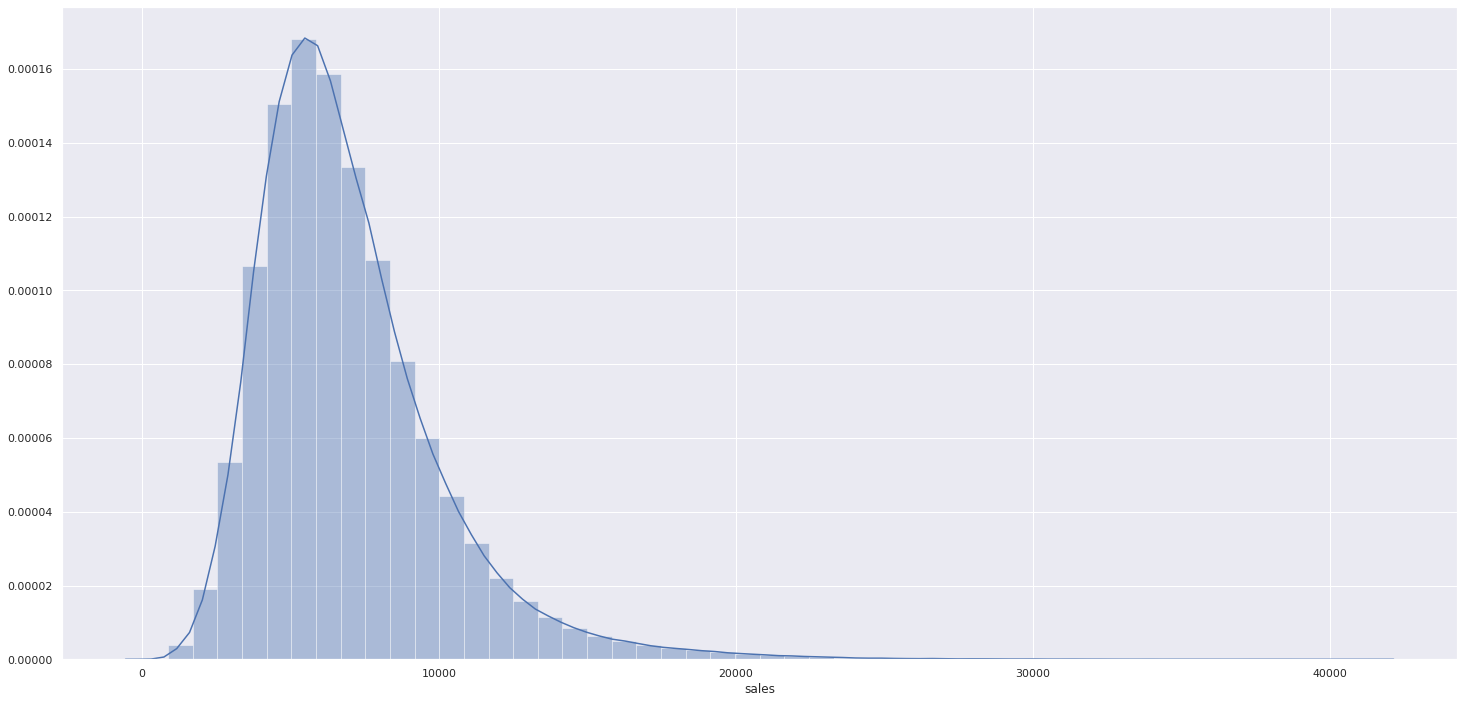

In [29]:
sns.distplot(df3['sales'])

### 4.1.2. Numerical Variable

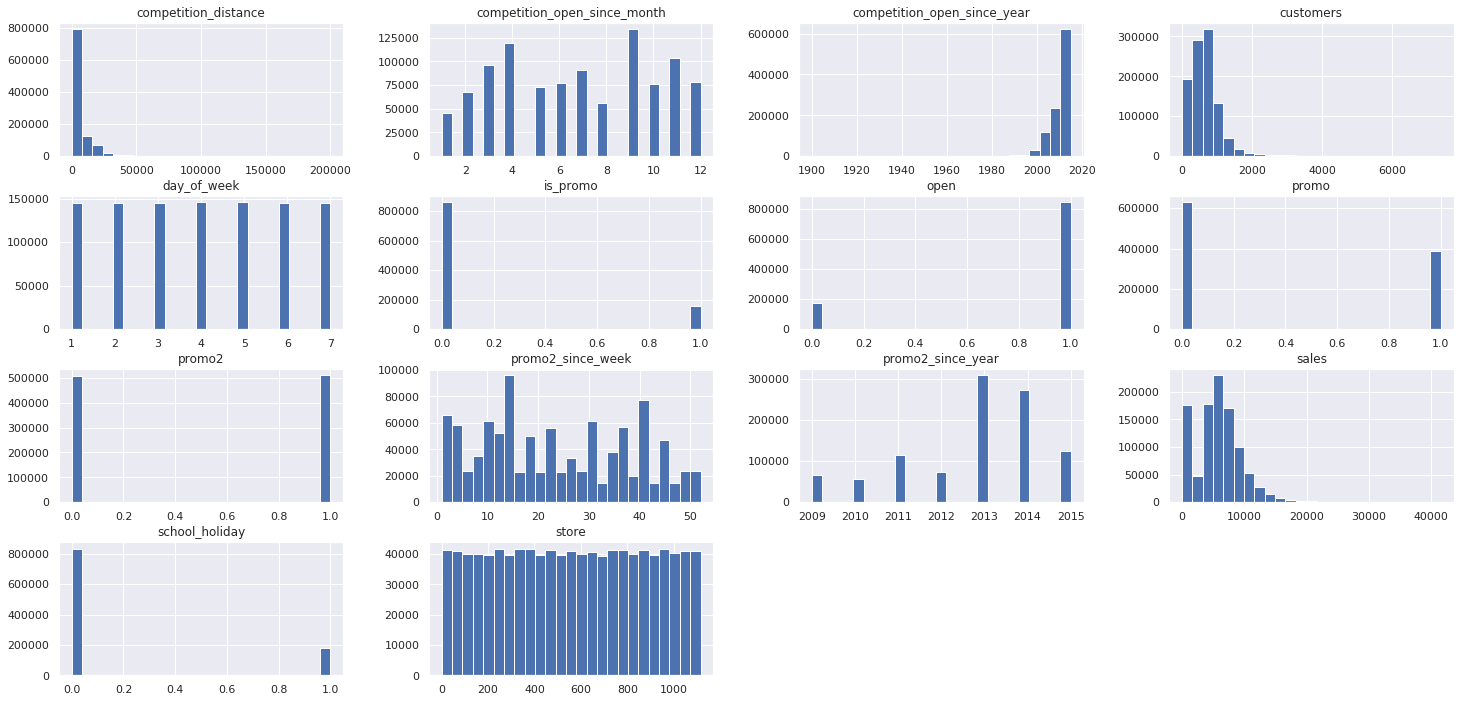

In [30]:
num_attributes.hist(bins = 25);

### 4.1.3. Categorical Variable

In [31]:
df4.select_dtypes(include = 'object').columns

Index(['state_holiday', 'store_type', 'assortment', 'year_week'], dtype='object')

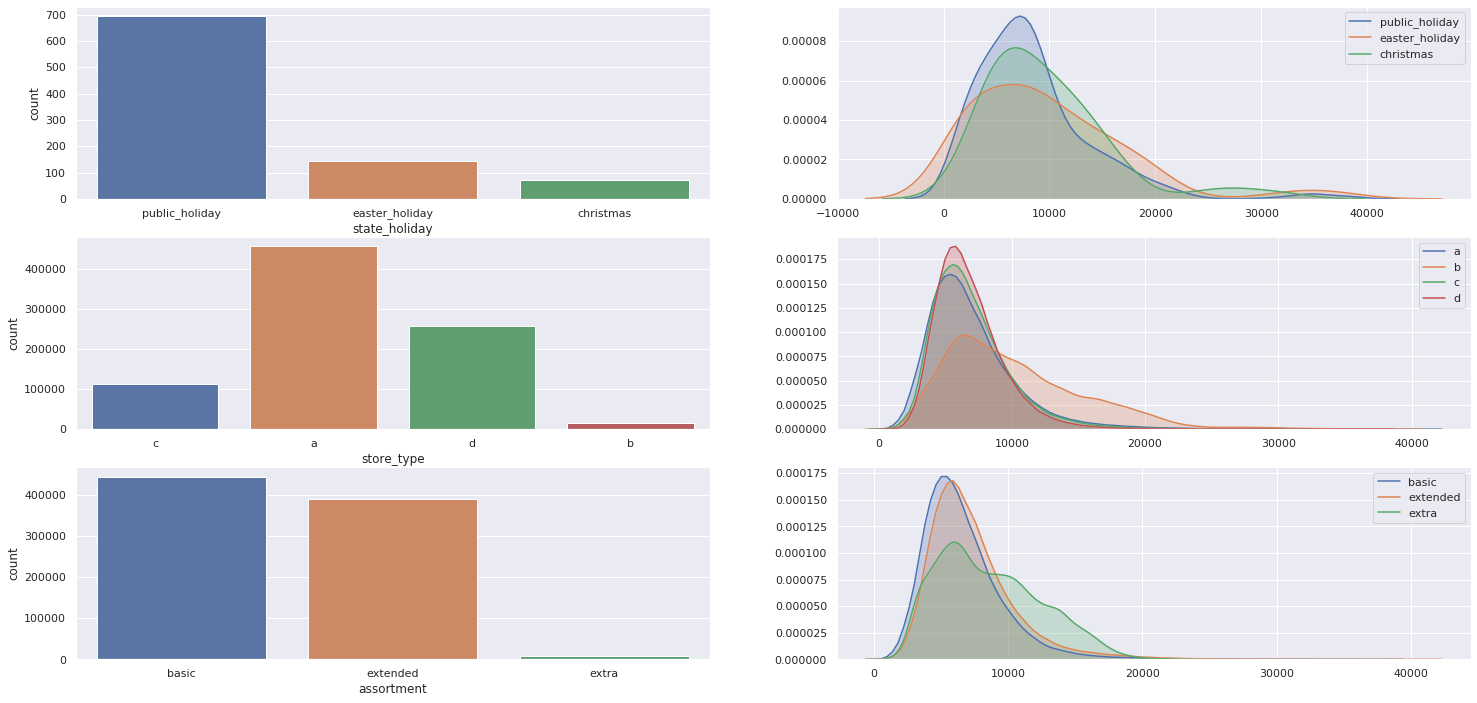

In [32]:
#state_holiday
a = df4[df4['state_holiday'] != 'regular_day']
plt.subplot(3,2,1)
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],label = 'public_holiday',shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],label = 'easter_holiday',shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],label = 'christmas',shade = True)

#store_type
plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],label = 'a',shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],label = 'b',shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],label = 'c',shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],label = 'd',shade = True)

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label  = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)


## 4.2. Análise Bivariada

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


### H1. Lojas com maior sortimentos deveriam vender mais. 

**Falsa** Lojas com maior sortimento vendem menos

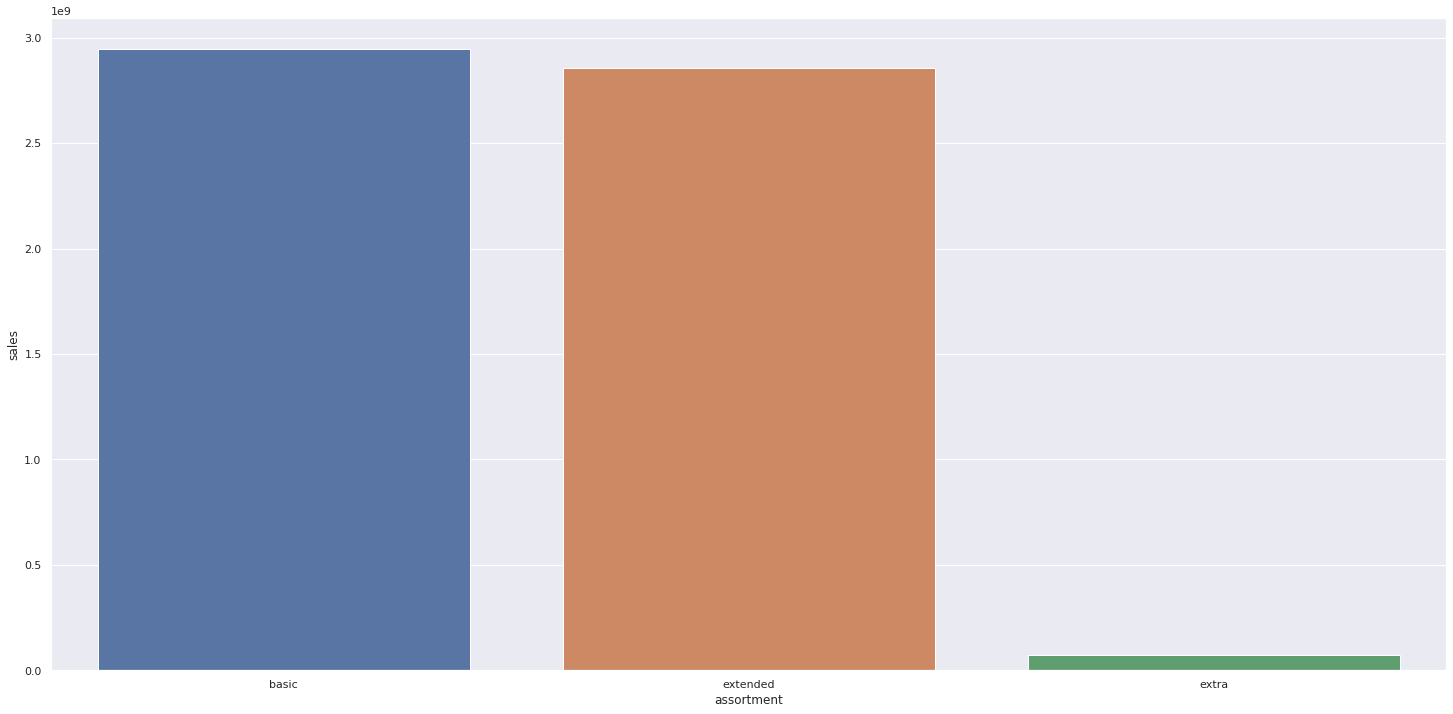

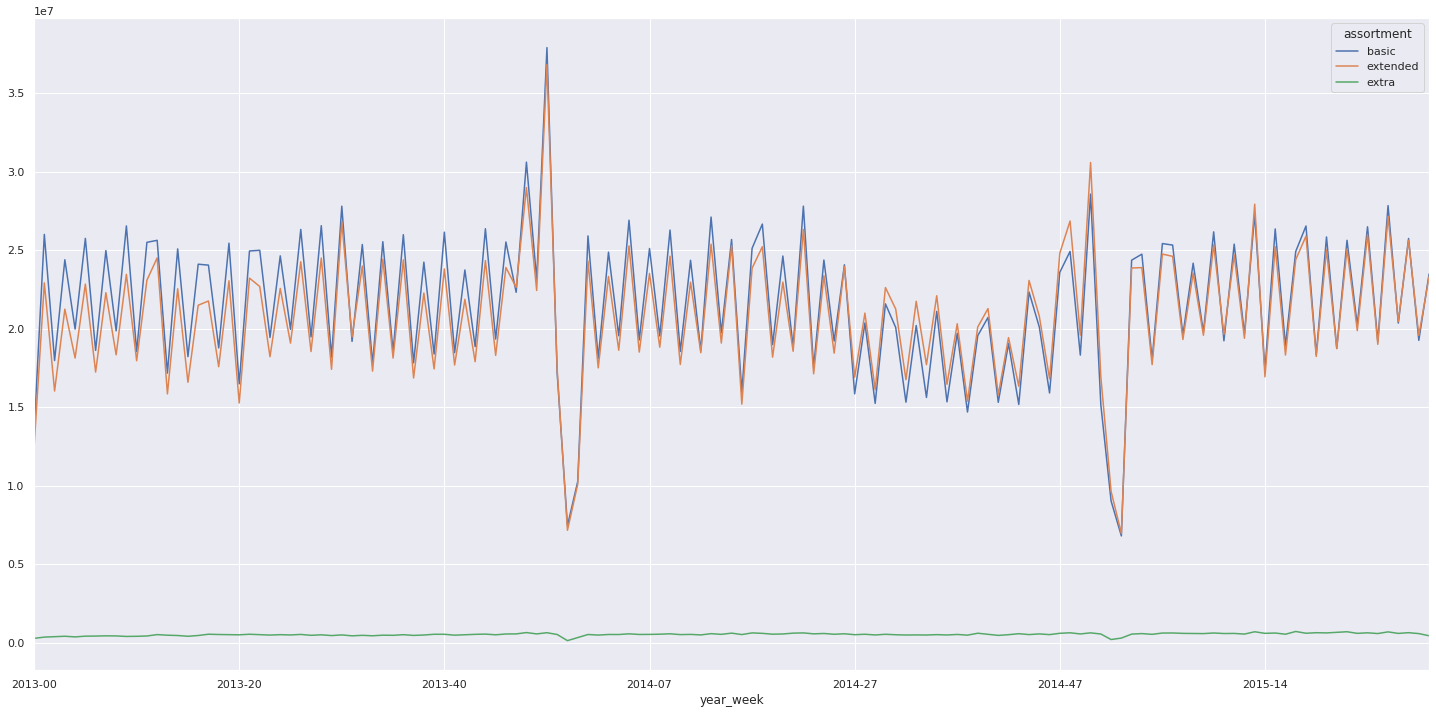

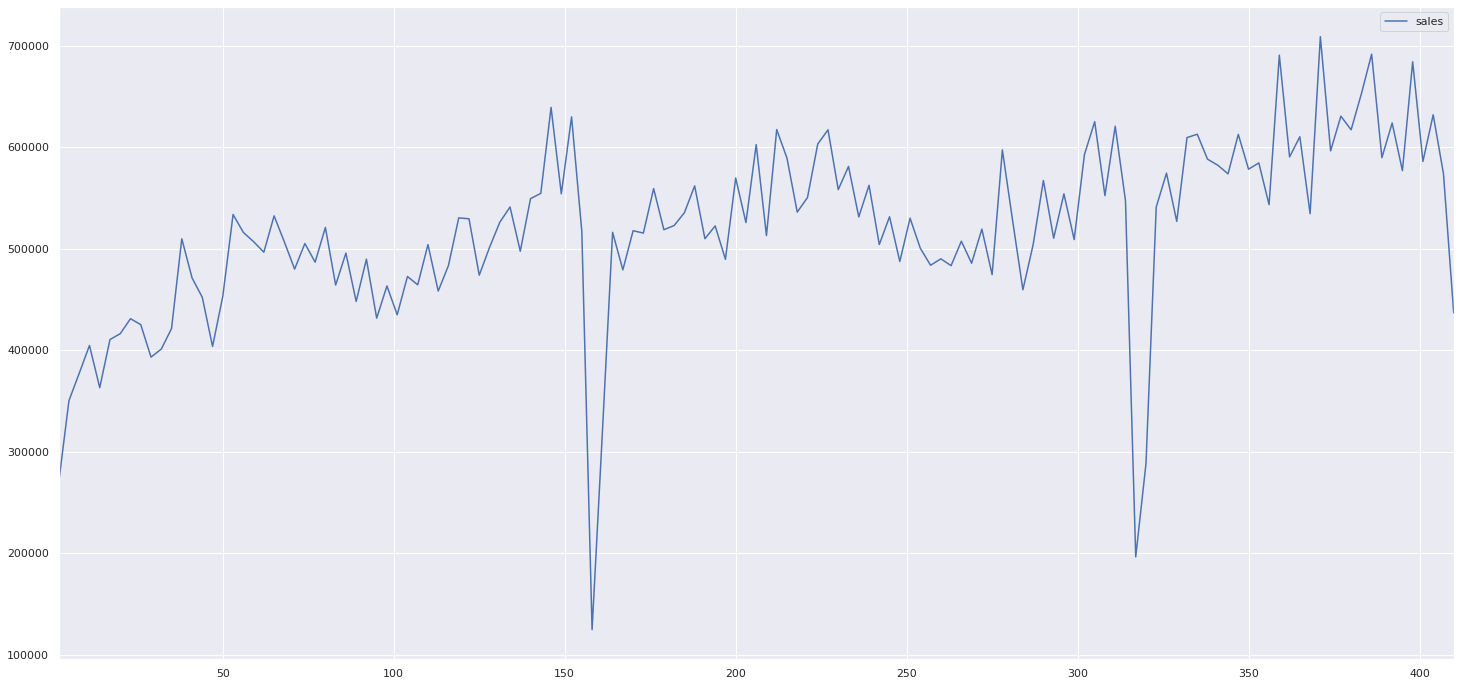

In [33]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

aux2 = df4[['assortment','sales','year_week']].groupby(['year_week','assortment']).sum().reset_index()
aux3 = aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales')
aux3.plot()


aux4 = aux2[aux2['assortment'] == 'extra']
aux4.pivot(index = 'year_week',columns = 'assortment', values = 'sales')
aux4.plot()

### **H2** Lojas com competidores mais próximos vendem menos

**Falsa** Lojas com competidores mais próximos vendem mais.

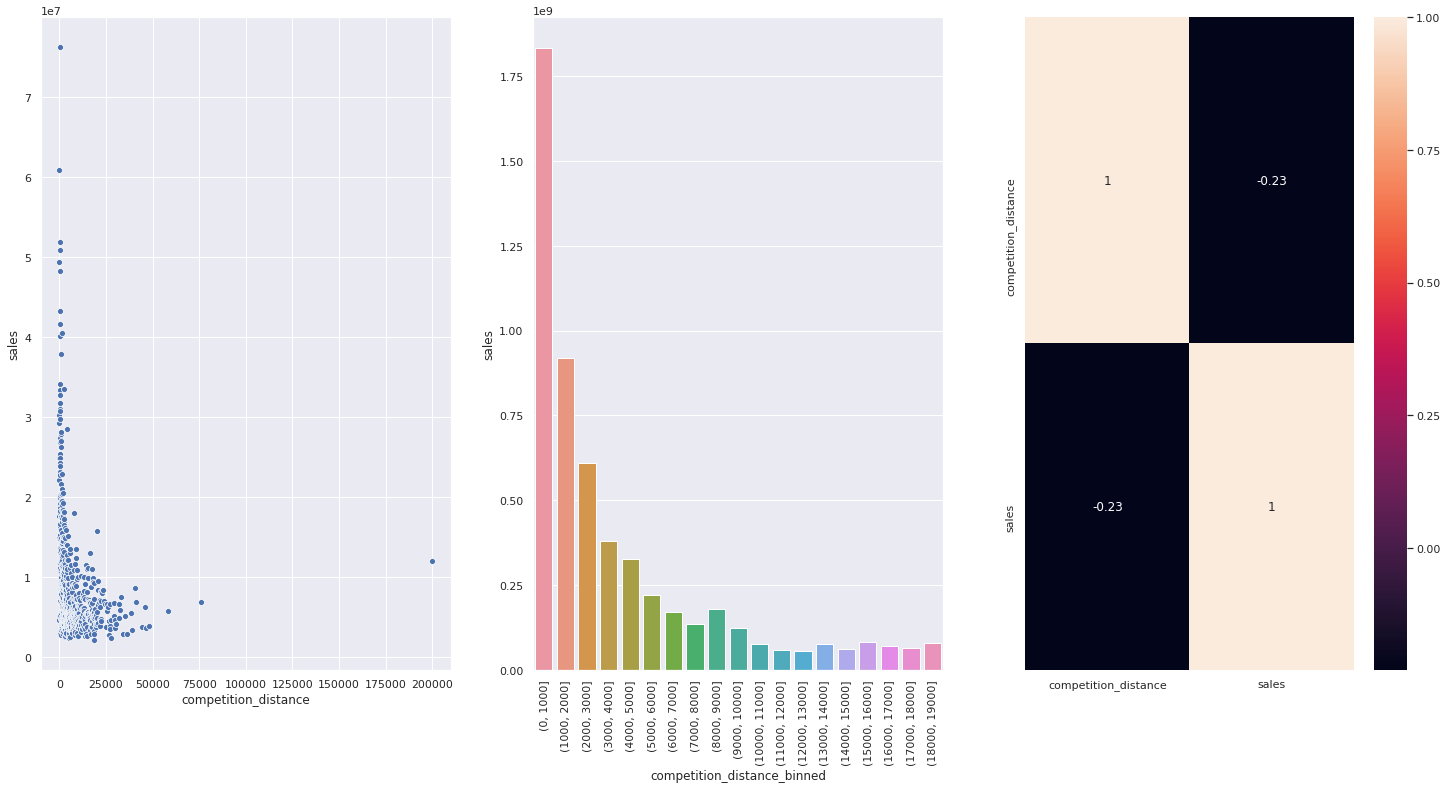

In [34]:
plt.subplot(1,3,1)
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90)
    
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H3. Lojas com competidores à mais tempo deveriam vender mais.

**Falsa** Lojas com competidores à mais tempo vendem menos.

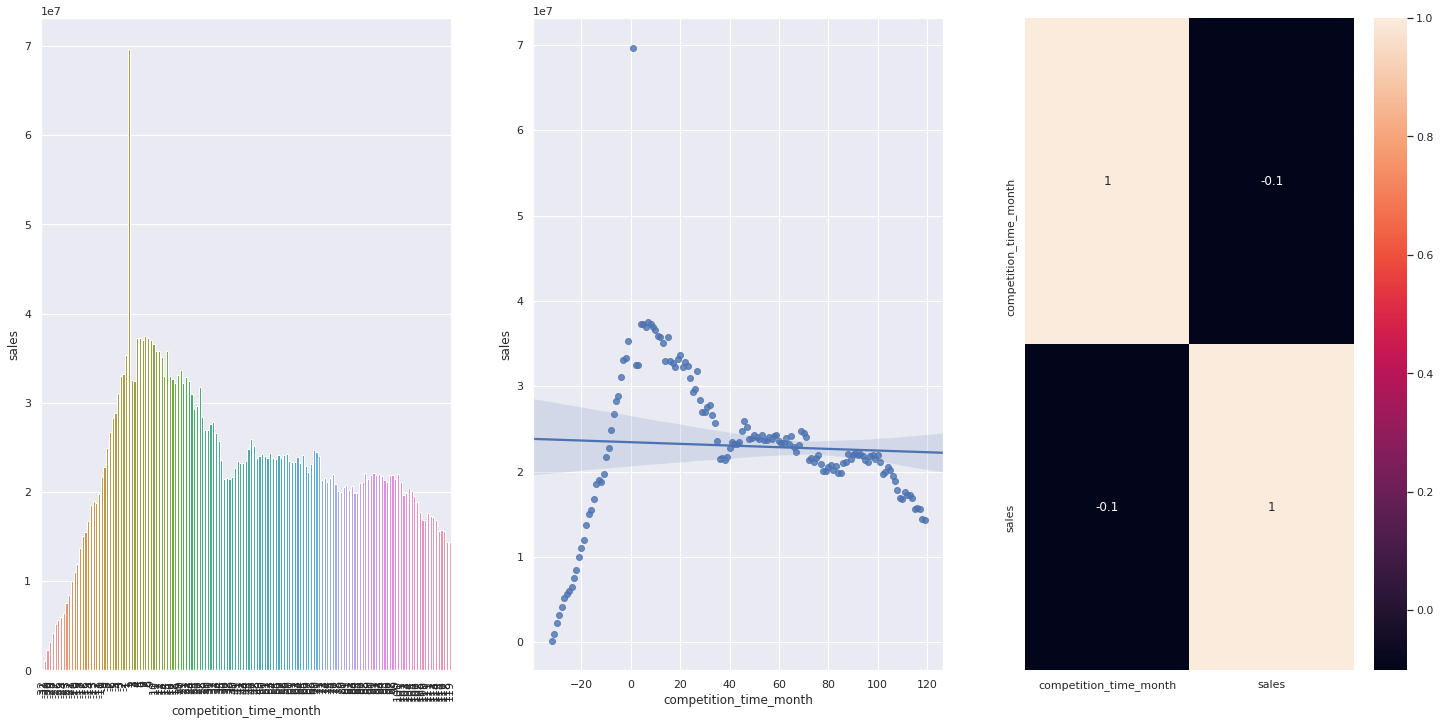

In [35]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

**Falsa** Lojas com promoções ativas vendem menos depois de certo tempo de duração.

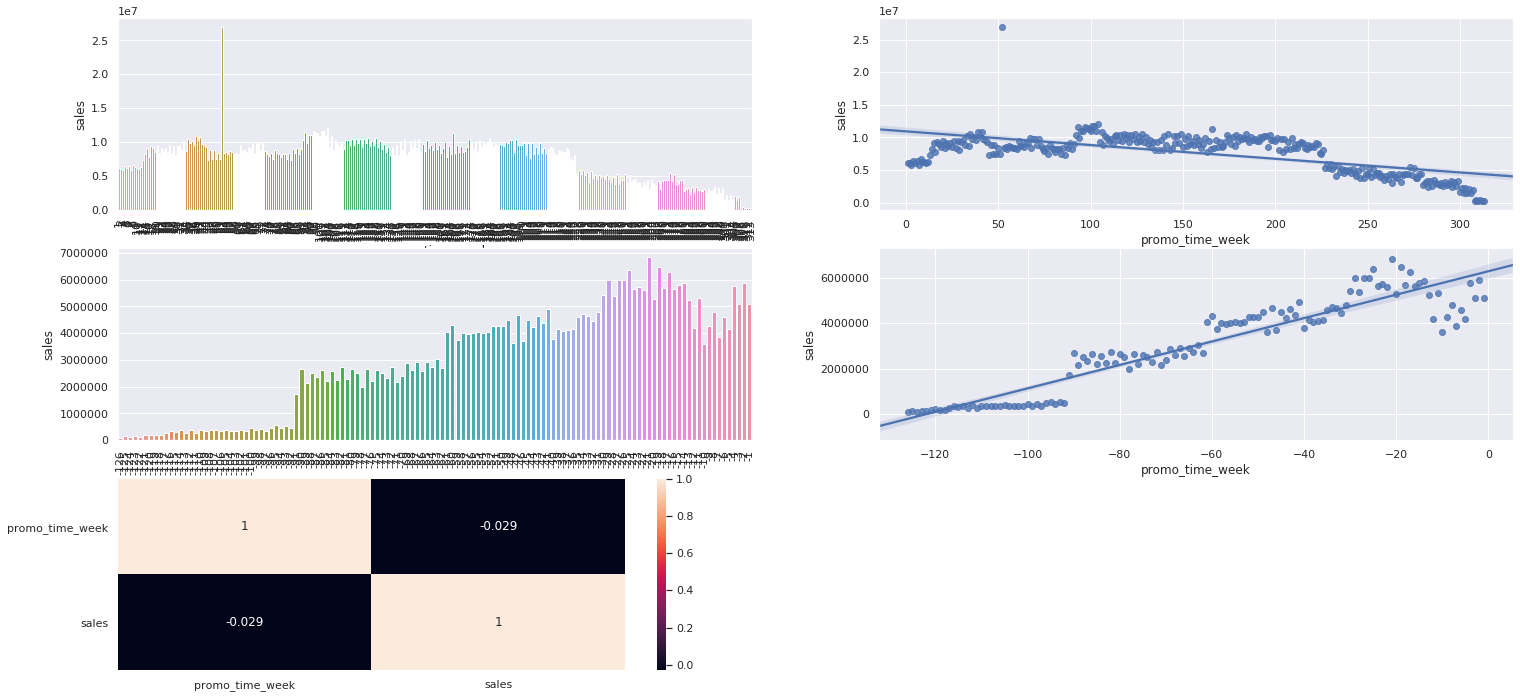

In [36]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(3,2,1)
aux2 = aux1[aux1['promo_time_week'] > 0] #periodo extendido
sns.barplot(x = 'promo_time_week',y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(3,2,2)
sns.regplot(x = 'promo_time_week',y = 'sales', data = aux2);

plt.subplot(3,2,3)
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x = 'promo_time_week',y = 'sales', data = aux3);
plt.xticks(rotation = 90);### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

plt.subplot(3,2,4)
sns.regplot(x = 'promo_time_week',y = 'sales', data = aux3);

plt.subplot(3,2,5)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True );

### <s>H5. Lojas com mais promoções deveriam vender mais.<s>

### H6. LOjas com mais promoções consecutivas deveriam vender mais.

**Falsa** Lojas com mais promoções consecutivas vendem menos.

In [37]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


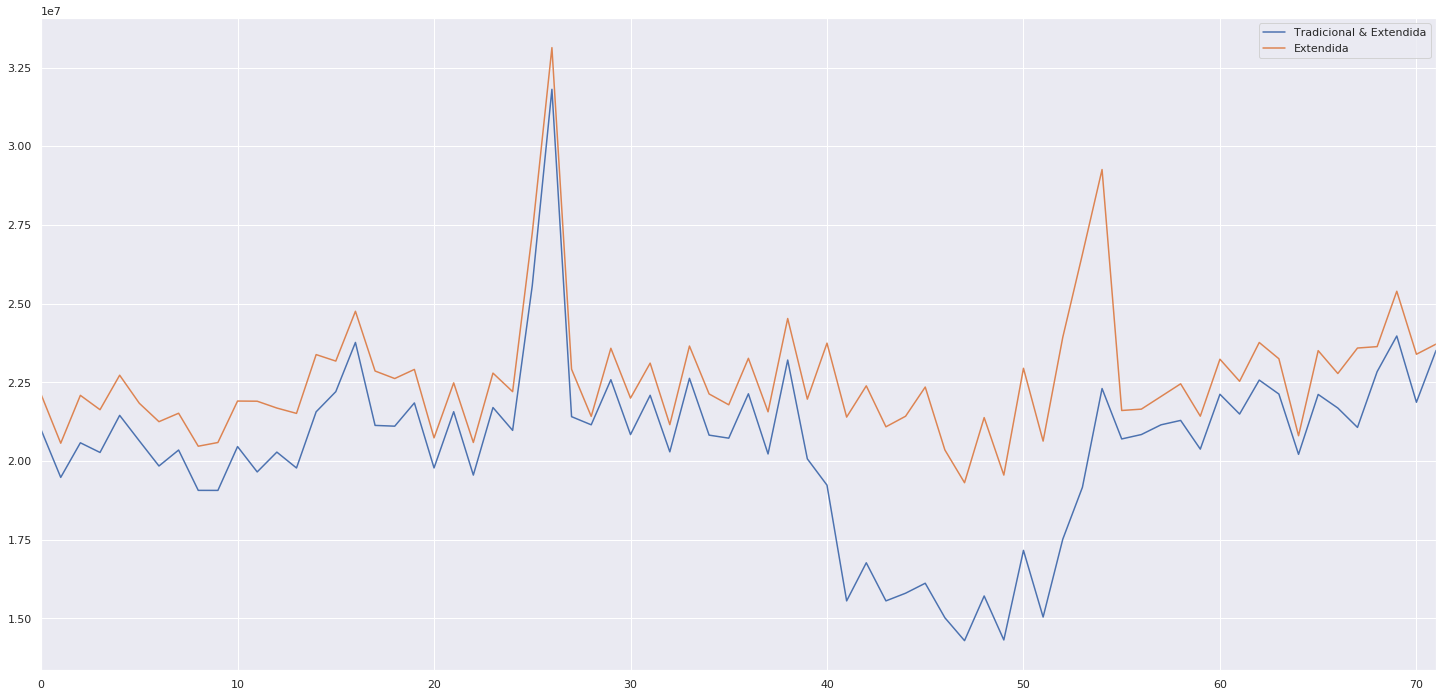

In [38]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()


aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)
ax.legend(labels = ['Tradicional & Extendida', 'Extendida'])

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.

**Falsa** Lojas abertas durante o feriado do Natal vendem menos.

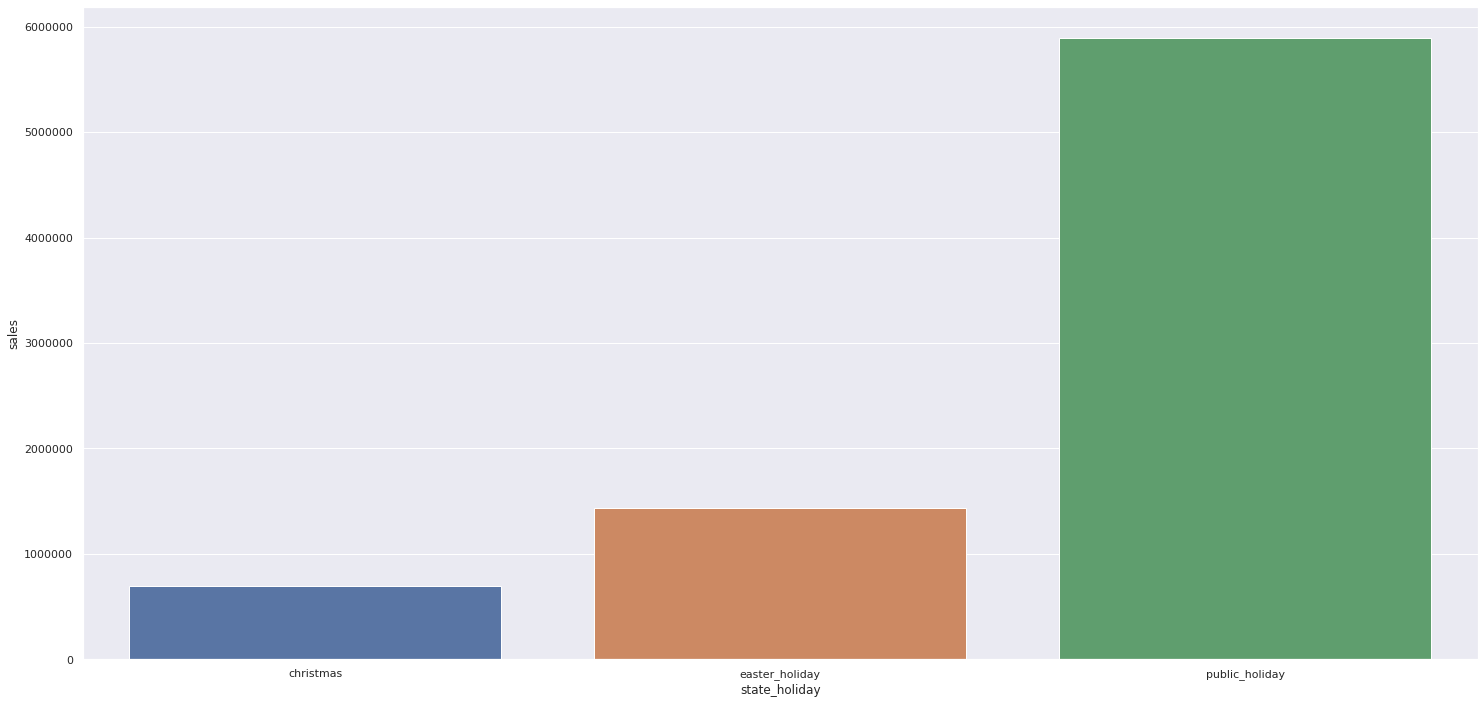

In [39]:
aux1 = df4[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

aux2 = aux1[aux1['state_holiday'] != 'regular_day']
sns.barplot(x = 'state_holiday', y = 'sales', data = aux2)

### H8. Lojas deveriam vender mais ao longo dos anos.

**Falsa** Lojas vendem menos ao longo dos anos.

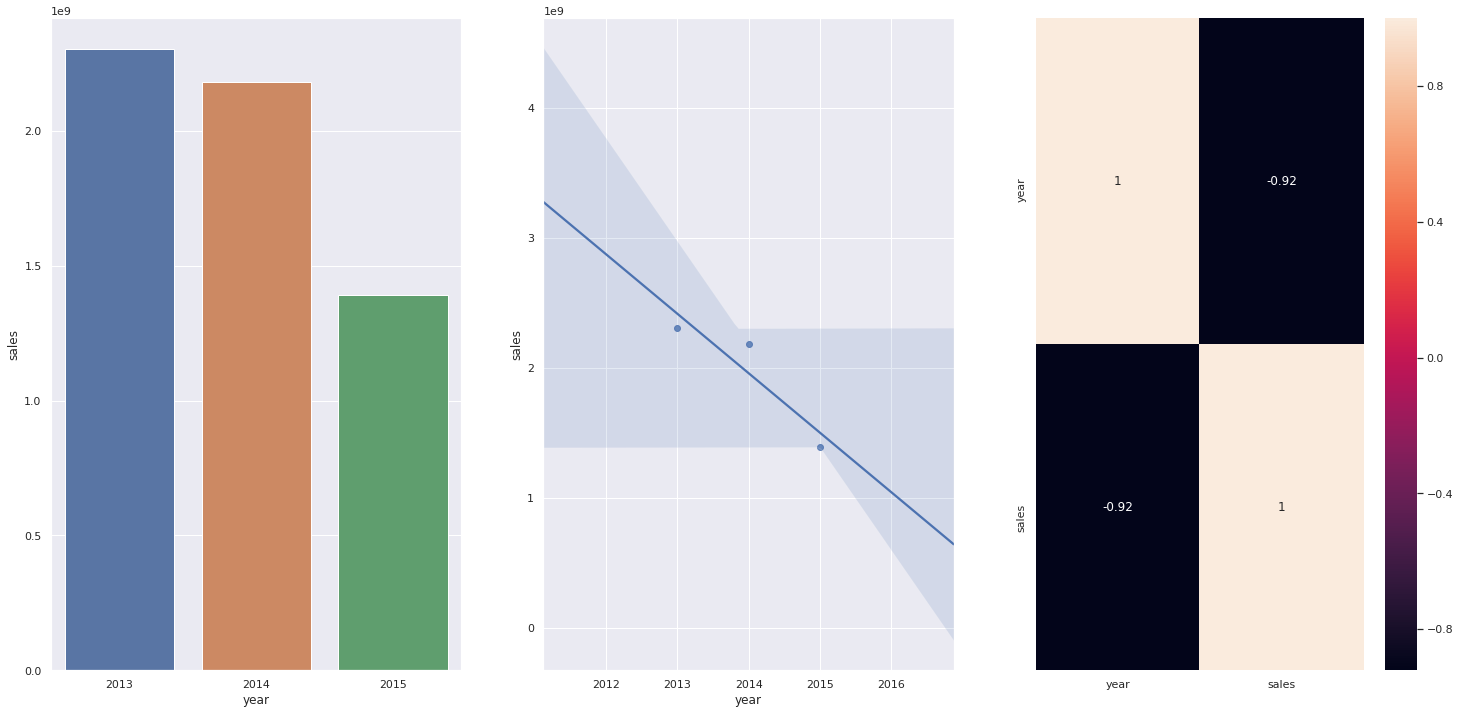

In [40]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'year',y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'year',y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### H9. Lojas deveriam vender mais no segundo semestre do ano.

**Falsa** Lojas vendem menos no segundo semestre do ano.

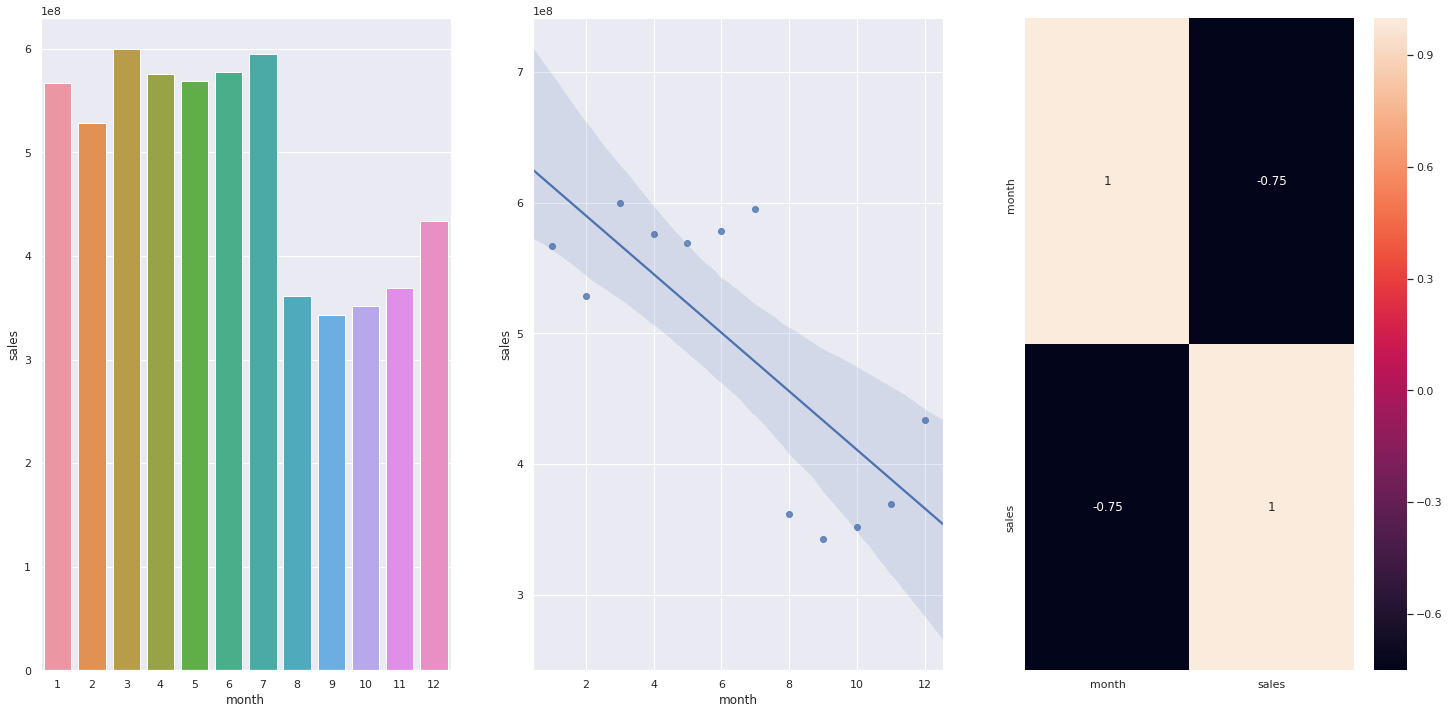

In [41]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month',y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'month',y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

**Verdadeira** Lojas vendem mais depois do dia 10 de cada mês.

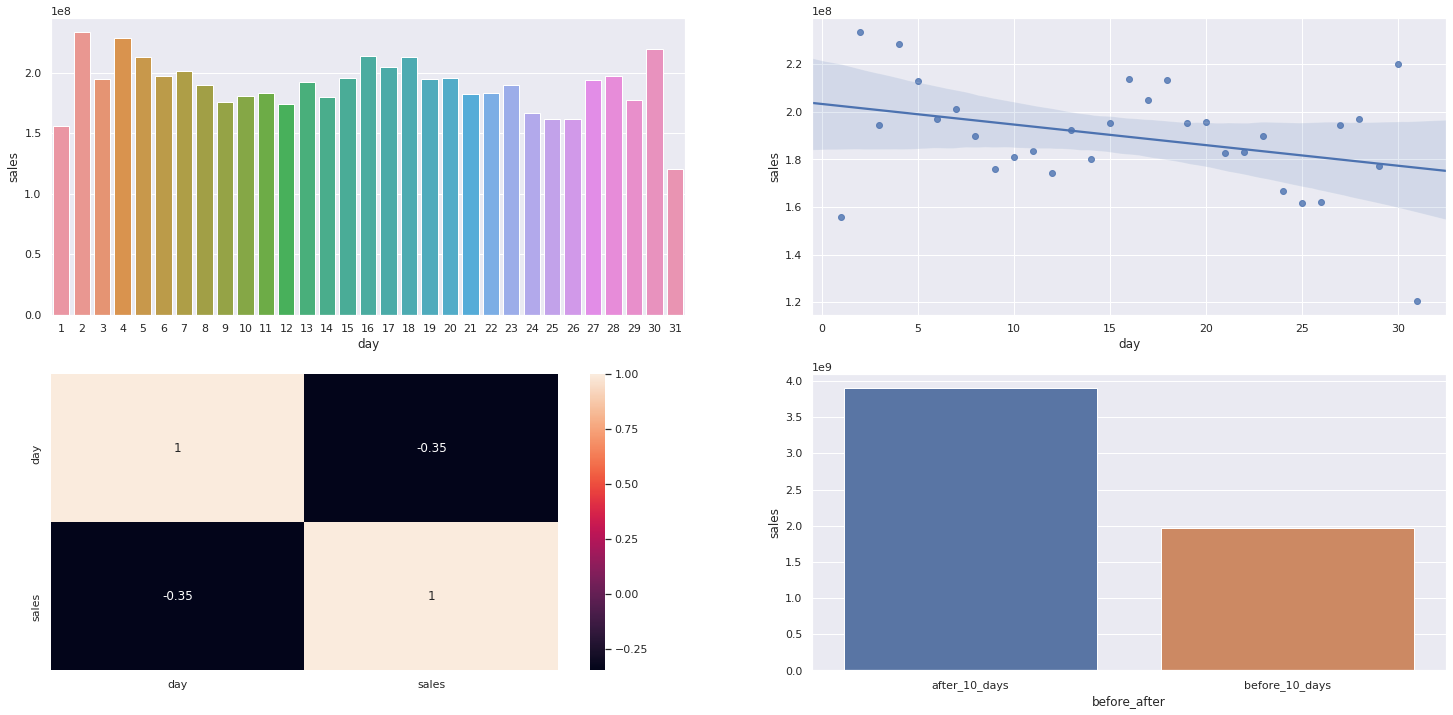

In [42]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day',y = 'sales', data = aux1)

plt.subplot(2,2,2)
sns.regplot(x = 'day',y = 'sales', data = aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x:'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales', data = aux2)

### H11. Lojas deveriam vender menos aos finais de semana.

**Verdadeira** Lojas vendem menos aos finais de semana.

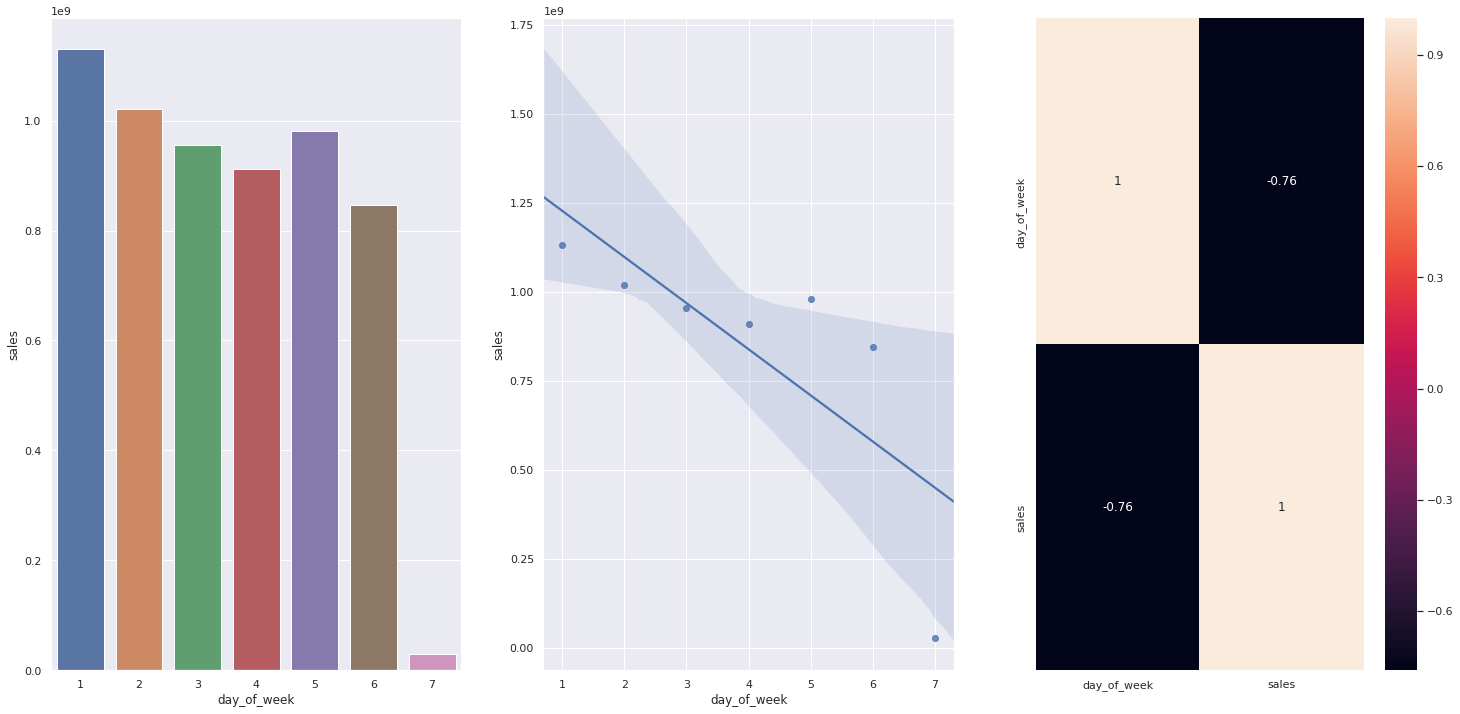

In [43]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week',y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week',y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### H12. Lojas deveriam vender menos durante os feriados escolares

**Verdadeira** Lojas vendem menos durante os feriados escolares exceto nos meses de julho e agosto.

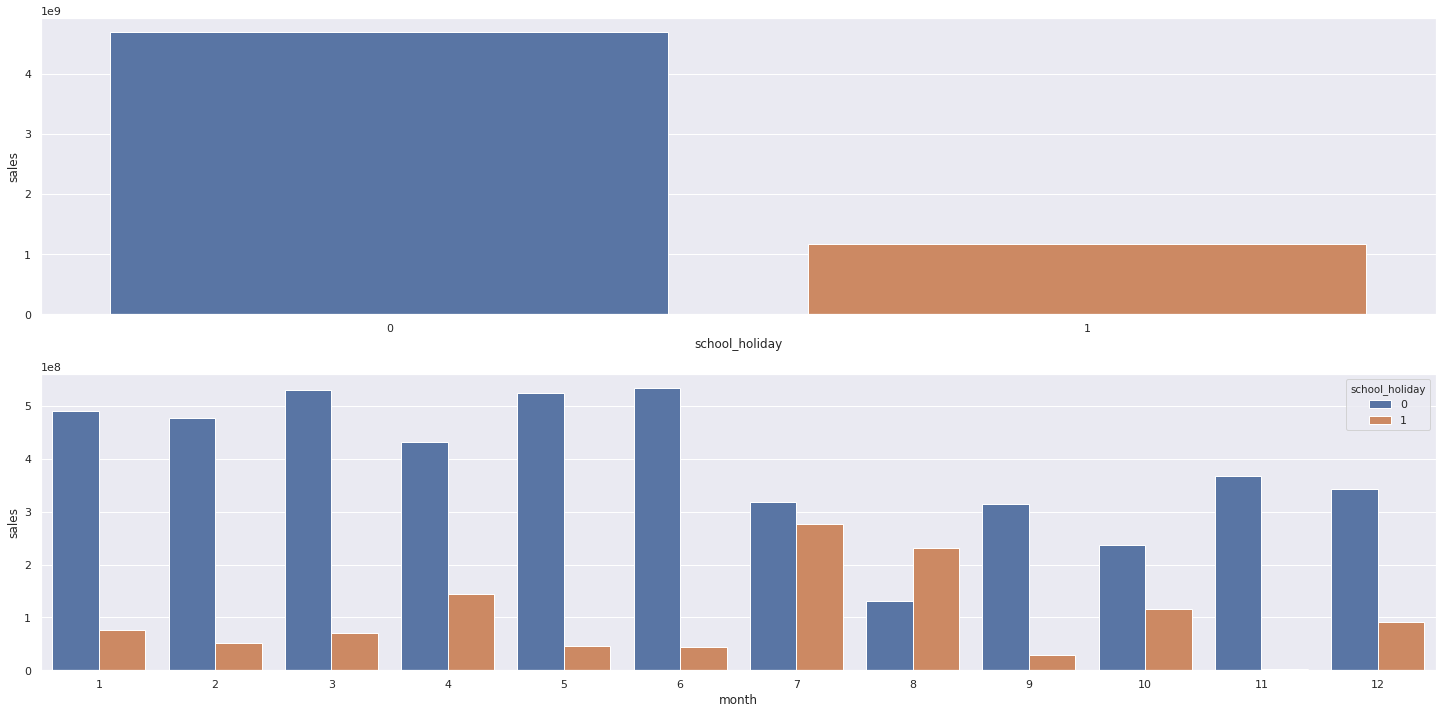

In [44]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x = 'school_holiday',y = 'sales', data = aux1)

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x = 'month',y = 'sales',hue = 'school_holiday', data = aux2)


### 4.2.1. Resumo das Hipóteses

In [45]:
tab = [['Hipóteses','Conclusao','Relevancia'],
      ['H1','Falsa','Baixa'],
      ['H2','Falsa','Media'],
      ['H3','Falsa','Media'],
      ['H4','Falsa','Baixa'],
      ['H5','-','-'],
      ['H6','Falsa','Baixa'],
      ['H7','Falsa','Media'],
      ['H8','Falsa','Alta'],
      ['H9','Falsa','Alta'],
      ['H10','Verdadeira','Alta'],
      ['H11','Verdadeira','Alta'],
      ['H12','Verdadeira','Baixa']]

print(tabulate(tab, headers = 'firstrow'))

Hipóteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes

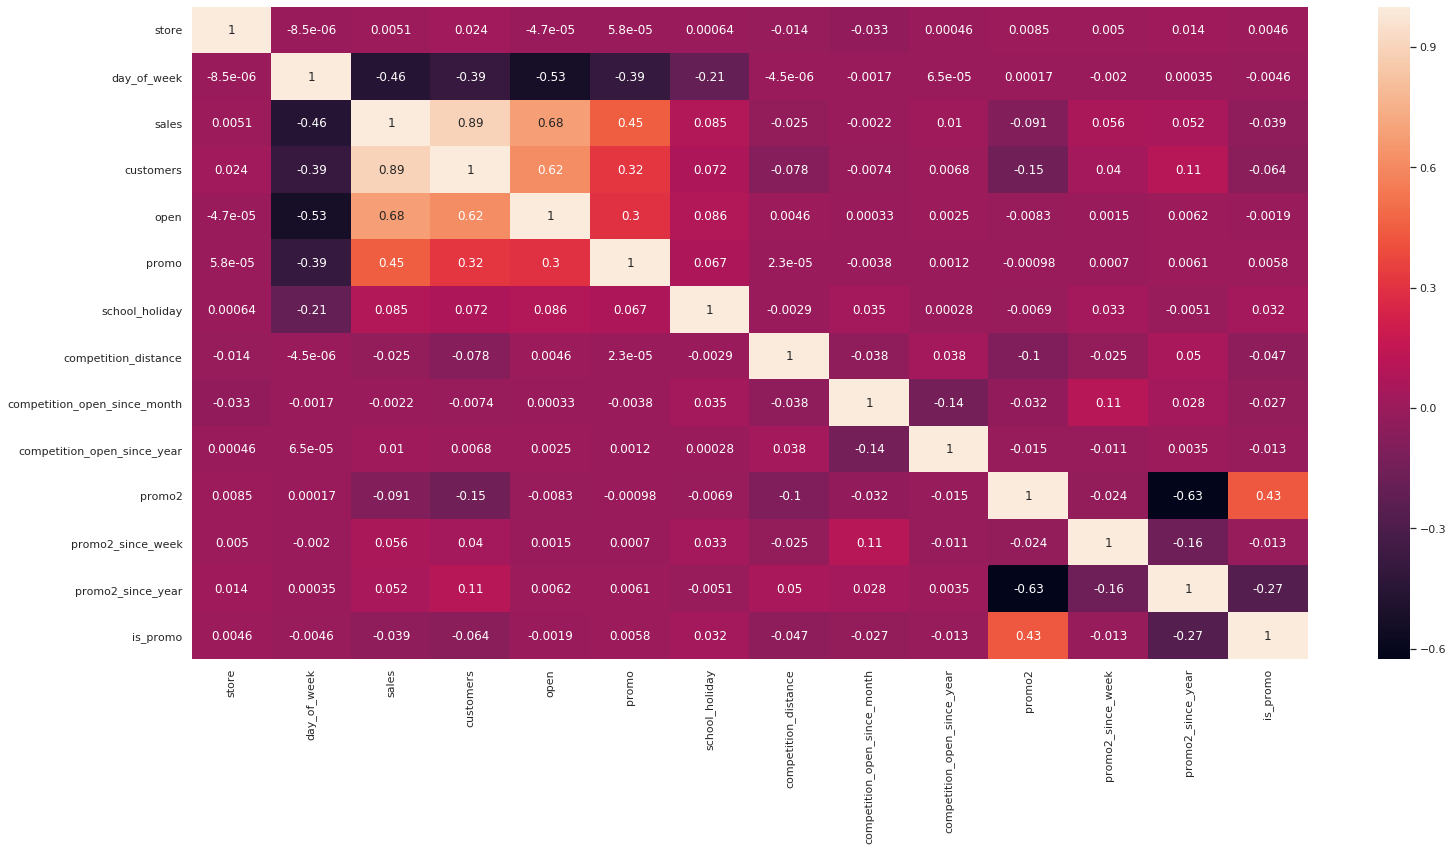

In [46]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)

### 4.3.2. Categorical Attributes

In [47]:
#only categorical data
a = df4.select_dtypes(include = 'object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


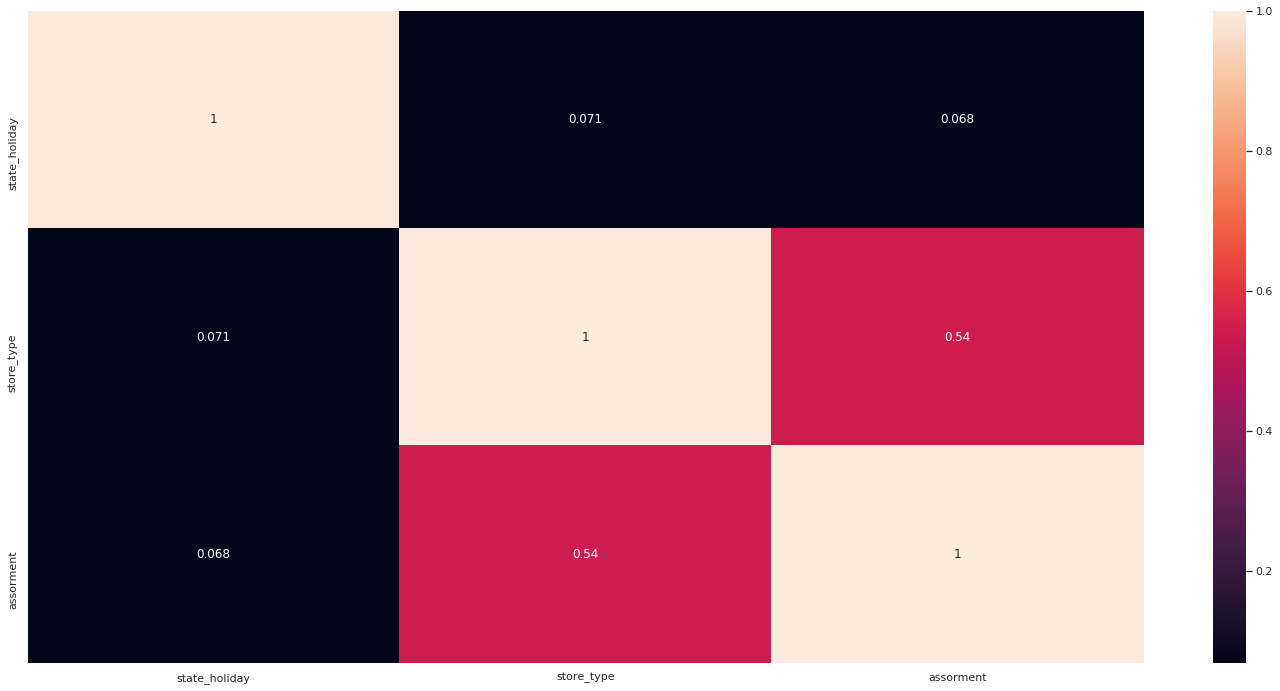

In [48]:
#calculate cramer v
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assorment': [a7,a8,a9]
             })

#final dataset
d = d.set_index(d.columns)
sns.heatmap(d , annot = True)

# 5.0. PREPARAÇÃO DOS DADOS

In [49]:
df5 = df4.copy()

## 5.1. Normalização

Como não há uma distribuição normal em nossas variáveis numéricas, não utilizaremos a normalização.

## 5.2. Rescaling

Iremos verificar quais variáveis possuem alta quantidade de outliers. Caso seja encontrado, iremos utilizar o RobustScaler que performar melhor para essas variáveis, pois, irá utilizar os quartis ao invés dos máximos e mínimos. 

Para variáveis que não possuem outliers, utilizaremos o MinMaxScaler.



In [50]:
a = df5.select_dtypes(include = ['int64','float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


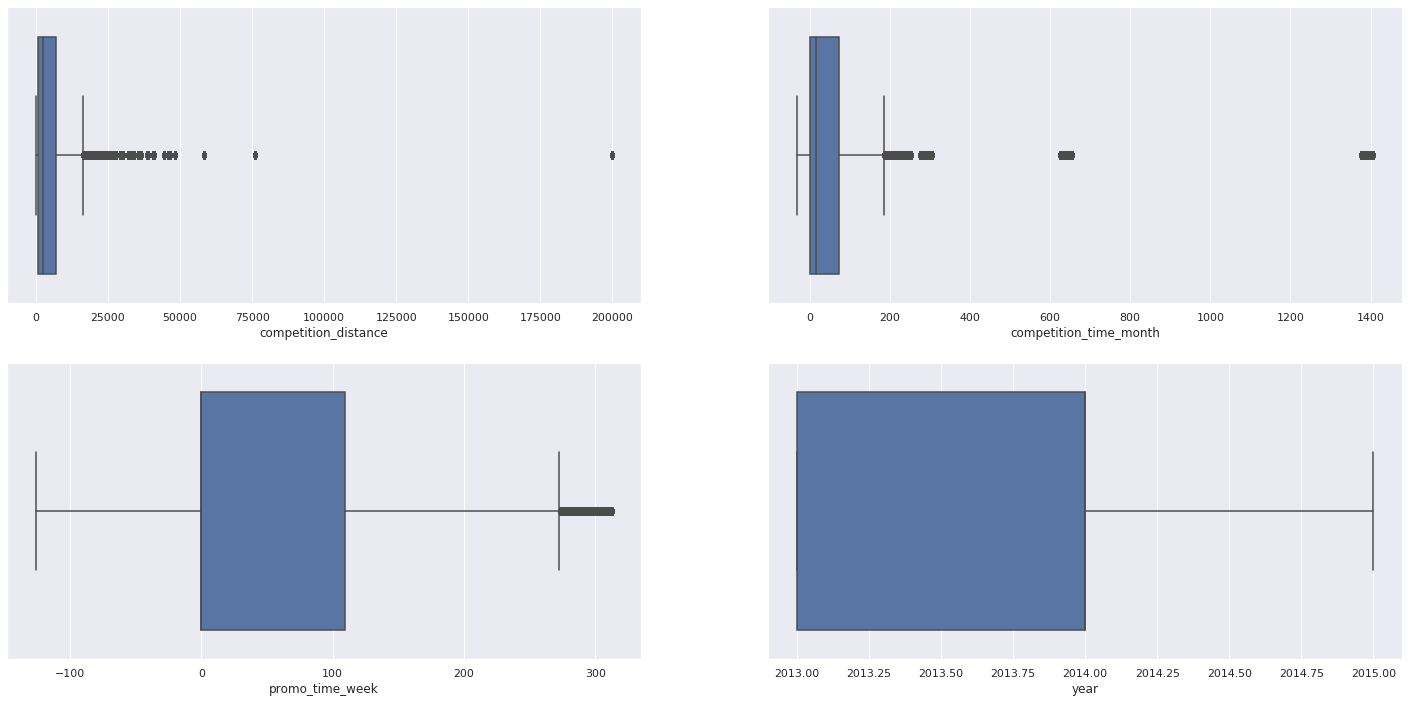

In [51]:
plt.subplot(2,2,1)
sns.boxplot(df5['competition_distance'])

plt.subplot(2,2,2)
sns.boxplot(df5['competition_time_month'])

plt.subplot(2,2,3)
sns.boxplot(df5['promo_time_week'])

plt.subplot(2,2,4)
sns.boxplot(df5['year'])

In [52]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)


## 5.3. Transformação

### 5.3.1. Encoding

In [53]:
#state_holiday - OneHotEncoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

#store_type - LabelEncoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment - OrdinalEncoder
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

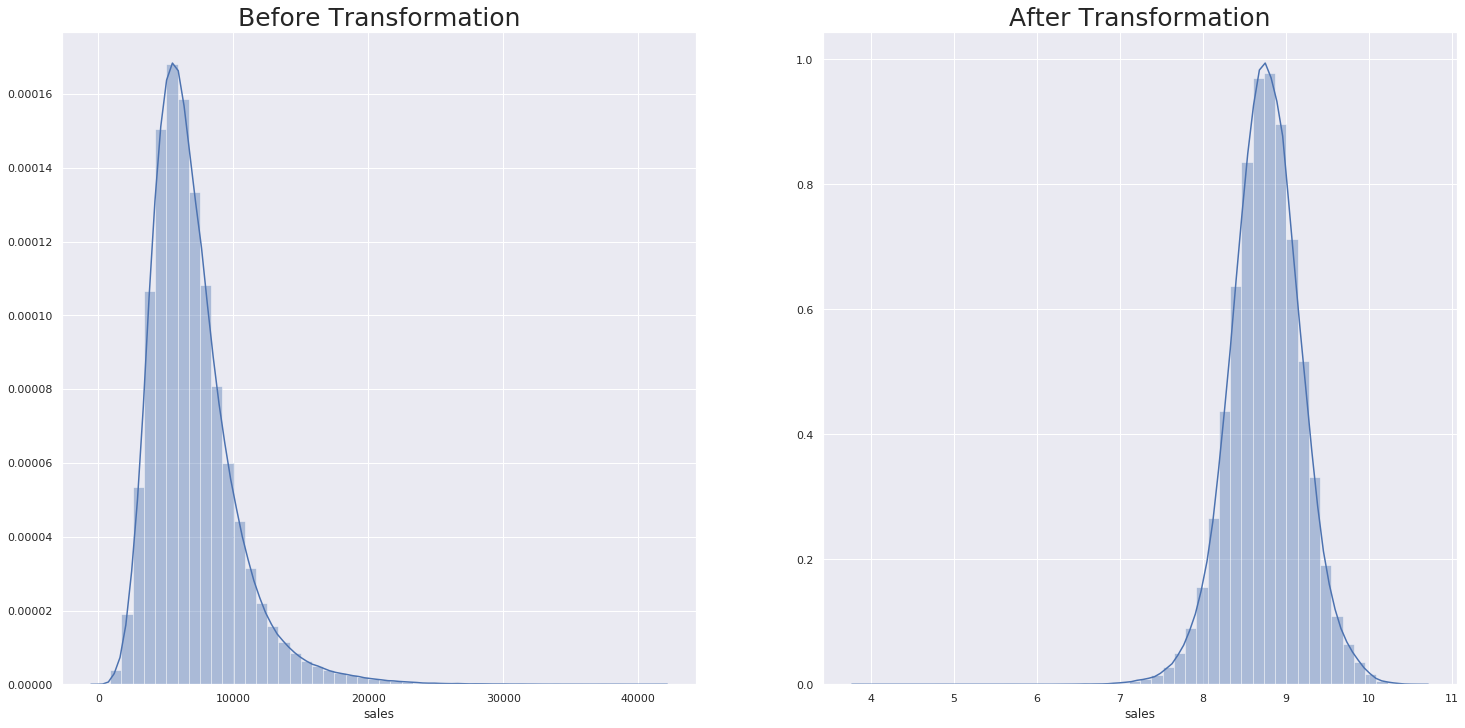

In [54]:
plt.subplot(1,2,1)
sns.distplot(df5['sales'])
plt.title('Before Transformation', fontsize = 25)

plt.subplot(1,2,2)
sns.distplot(np.log1p(df5['sales']))
plt.title("After Transformation", fontsize = 25)

#transformation
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [55]:
#month 
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2* np.pi/12) ))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2* np.pi/12) ))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2* np.pi/30) ))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2* np.pi/30) ))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2* np.pi/52) ))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2* np.pi/52) ))

#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2* np.pi/7) ))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2* np.pi/7) ))


# 6.0. SELEÇÃO DAS VARIÁVEIS

In [56]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [57]:
cols_drop = ['month','week_of_year','day','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop,axis = 1)

In [58]:
df6[['date','store']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 7*6)

Timestamp('2015-06-19 00:00:00')

In [59]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] > '2015-06-19']
y_test = X_test['sales']

print("Training min date: {}".format(X_train['date'].min()))
print("Training max date: {}".format(X_train['date'].max()))

print('\n')

print("Test Min date: {}".format(X_test['date'].min()))
print("Test Max Date: {}".format(X_test['date'].max()))

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00


Test Min date: 2015-06-20 00:00:00
Test Max Date: 2015-07-31 00:00:00



## 6.2. Boruta as Feature Selector

In [60]:
#training and test dataset for boruta
#X_train_n = X_train.drop(['date','sales'], axis = 1).values
#y_train_n = y_train.values.ravel()

#define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs = -1)

#define boruta
#boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n,y_train_n)

### 6.2.1. Best features from boruta

In [ ]:
#cols_selected = bortua.support_.tolist()

#best features
#X_train_fs = X_train.drop(['date','sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#not selected boruta
#cols_not_selected_boruta = np.setdiff1d(x_train_fs.columns, cols_selected_boruta)
#cols_selected_boruta

## 6.3. Manual Feature Selection

In [63]:
cols_selected_boruta = ['Store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2','promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_cos',
                        'month_sin',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos',
                        'week_of_year_sin']

#columns to add
feat_to_add = ['date','sales']

#final_list
cols_selected_boruta.extend(feat_to_add)
cols_selected_boruta

['Store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'date',
 'sales']